In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters Vector

Load and normalization vector of parameters.

Concatenating all four DataFrames into one.

In [2]:
allpatients = pd.read_csv('Time_Male.csv')
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,29241.0,-29320.0,6289.637492,1.154522,-0.278947,Zdrowy
1,22856.0,-29453.0,5107.071001,2.979691,0.072257,Zdrowy
2,22061.0,-23299.0,6599.787734,0.712650,-0.001332,Zdrowy
3,9884.0,-13521.0,3353.459070,0.969484,0.309495,Zdrowy
4,13997.0,-19188.0,4252.315146,1.981925,-0.035390,Zdrowy


Features has diffrent rows, so they have to be normalized.

In [3]:
features = allpatients.drop(labels='Status', axis=1).columns
for i in features:
    allpatients[i] = (allpatients[i] - np.mean(allpatients[i]))/np.std(allpatients[i])
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,2.264942,-1.416545,0.316645,0.756835,-0.489999,Zdrowy
1,1.073054,-1.437500,-0.343569,2.560710,0.357747,Zdrowy
2,0.924651,-0.467857,0.489798,0.320119,0.180116,Zdrowy
3,-1.348430,1.072796,-1.322592,0.573956,0.930400,Zdrowy
4,-0.580656,0.179885,-0.820770,1.574585,0.097906,Zdrowy


Afterwards data have to be suffled, in order to avoid overfitting

In [4]:
allpatients = allpatients.sample(frac=1).reset_index(drop=True)
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,-2.105937,0.632249,-0.278684,-0.257512,-0.834215,Zdrowy
1,-0.251183,-0.584769,-0.620533,2.814649,-0.355351,Chory
2,-1.200587,1.495223,-1.936462,-0.181367,0.006974,Chory
3,0.105170,-0.116806,-0.070716,0.706834,-0.406294,Zdrowy
4,-0.817727,1.604729,-0.928838,-0.982717,1.388451,Chory


# PCA

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=3)
pca.fit(allpatients.drop(['Status'], axis=1))
X = pca.transform(allpatients.drop(['Status'], axis=1))
X = pd.DataFrame(X, columns=['A','B','C'])
X['Status'] = allpatients['Status']

In [12]:
from mpl_toolkits.mplot3d import Axes3D

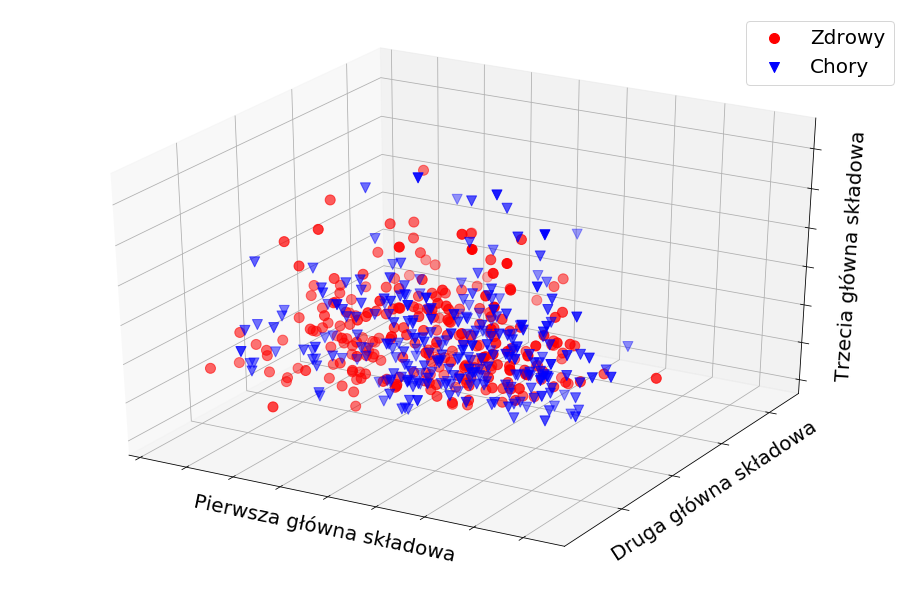

In [13]:
fig = plt.figure()
fig.set_size_inches(16, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[X['Status']=='Zdrowy']['A'],
           X[X['Status']=='Zdrowy']['B'],
           X[X['Status']=='Zdrowy']['C'],
           s=100,
           c='r',
           marker='o',
           label='Zdrowy')
ax.scatter(X[X['Status']=='Chory']['A'],
           X[X['Status']=='Chory']['B'],
           X[X['Status']=='Chory']['C'],
           s=100,
           c='b',
           marker='v',
           label='Chory')
plt.legend(loc='upper right', frameon = True, fontsize=20)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('Pierwsza główna składowa', fontsize=20)
ax.set_ylabel('Druga główna składowa', fontsize=20)
ax.set_zlabel('Trzecia główna składowa', fontsize=20)
plt.show()

# Dummy variables

We'll need to convert categorical features (Status) to dummy variables, because our alghoritm can't understant what means 'healthy'.

In [5]:
status = pd.get_dummies(allpatients['Status'],drop_first=True)

In [6]:
allpatients.drop(['Status'],axis=1,inplace=True)

In [7]:
allpatients['Chory'] = status
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Chory
0,-2.105937,0.632249,-0.278684,-0.257512,-0.834215,1
1,-0.251183,-0.584769,-0.620533,2.814649,-0.355351,0
2,-1.200587,1.495223,-1.936462,-0.181367,0.006974,0
3,0.105170,-0.116806,-0.070716,0.706834,-0.406294,1
4,-0.817727,1.604729,-0.928838,-0.982717,1.388451,0


# Logistic regression algorithm

# Train test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(allpatients.drop(['Chory'],axis=1), 
                                                    allpatients['Chory'], 
                                                    test_size=0.25, 
                                                    random_state=42)

### K-fold validation
I dicided to use k-fold validation due to low num of train examples

In [11]:
num_folds = 5

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# Training and predicting

In [12]:
from sklearn.linear_model import LogisticRegression

In [20]:
results = {}
best_acc = -1
best_model = None
C = [1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for reg in C:
    #reset accuraties for folds
    train_acc = 0 
    val_acc = 0
    
    for i in range(num_folds):
        logModel = LogisticRegression(penalty='l1', C=reg, solver='liblinear')
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        logModel.fit(train_set, labels_set)
        #sum acc for each fold
        y_train_pred = logModel.predict(train_set)
        train_acc += np.mean(y_train_pred == labels_set) 
        
        y_val_pred = logModel.predict(X_train_folds[i])
        val_acc += np.mean(y_val_pred == y_train_folds[i])
        
    #compute mean for accuraties
    train_acc /= num_folds
    val_acc /= num_folds
    results[reg] = (train_acc, val_acc)
    if val_acc > best_acc:
            best_acc = val_acc
            best_model = logModel
            
# Print out results.
for C in sorted(results):
    train_accuracy, val_accuracy = results[C]
    print('C %e train accuracy: %f val accuracy: %f' % (
                C, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

C 1.000000e-02 train accuracy: 0.480668 val accuracy: 0.480547
C 1.000000e-01 train accuracy: 0.567028 val accuracy: 0.526565
C 1.000000e+00 train accuracy: 0.612332 val accuracy: 0.555686
C 2.000000e+00 train accuracy: 0.610518 val accuracy: 0.562974
C 3.000000e+00 train accuracy: 0.610519 val accuracy: 0.562944
C 4.000000e+00 train accuracy: 0.611122 val accuracy: 0.567764
C 5.000000e+00 train accuracy: 0.609915 val accuracy: 0.567764
C 6.000000e+00 train accuracy: 0.609311 val accuracy: 0.567764
C 7.000000e+00 train accuracy: 0.609311 val accuracy: 0.565354
C 8.000000e+00 train accuracy: 0.609311 val accuracy: 0.565354
C 9.000000e+00 train accuracy: 0.608707 val accuracy: 0.565354
C 1.000000e+01 train accuracy: 0.608707 val accuracy: 0.565354
best validation accuracy achieved during cross-validation: 0.567764


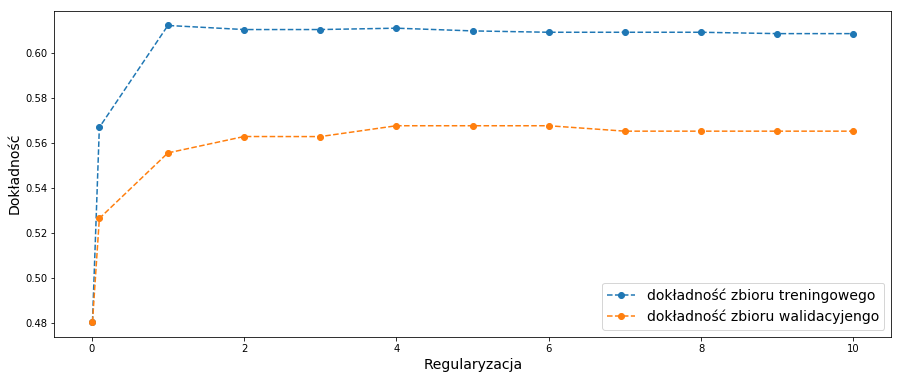

In [21]:
train = []
val = [] 
c = []
for C in sorted(results):
    train_accuracy, val_accuracy = results[C]
    train.append(train_accuracy)
    val.append(val_accuracy)
    c.append(C)
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.plot(c,train, 'o--', label='dokładność zbioru treningowego')
plt.plot(c,val, 'o--',label='dokładność zbioru walidacyjengo')
ax.set_xlabel('Regularyzacja', fontsize=14)
ax.set_ylabel('Dokładność', fontsize=14)
plt.legend(loc='lower right', frameon = True, fontsize=14)

In [22]:
prediction = best_model.predict(X_test)

# Evaluation
Check precission, recall, f1-score using classification report

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65        60
           1       0.53      0.57      0.55        44

   micro avg       0.61      0.61      0.61       104
   macro avg       0.60      0.60      0.60       104
weighted avg       0.61      0.61      0.61       104



In [25]:
print(confusion_matrix(y_test,prediction))

[[38 22]
 [19 25]]


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
results = {}
best_acc = -1
best_model = None
n_estimators = [10,20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130 , 140, 150, 200,250, 300]#, 400, 450, 500, 550, 600]

for n in n_estimators:
    #reset accuraties for folds
    val_acc = 0
    
    for i in range(num_folds):
        rf_model = RandomForestClassifier(n_estimators=n)
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        rf_model.fit(train_set, labels_set) 
        
        y_val_pred = rf_model.predict(X_train_folds[i])
        val_acc += np.mean(y_val_pred == y_train_folds[i])
        
    #compute mean for accuraties
    val_acc /= num_folds
    results[n] = val_acc
    if val_acc > best_acc:
            best_acc = val_acc
            best_model = rf_model

# Print out results.
for n in sorted(results):
    val_accuracy = results[n]
    print('n_estimators %e val accuracy: %f' % (n, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

n_estimators 1.000000e+01 val accuracy: 0.485689
n_estimators 2.000000e+01 val accuracy: 0.514634
n_estimators 3.000000e+01 val accuracy: 0.483103
n_estimators 4.000000e+01 val accuracy: 0.512195
n_estimators 5.000000e+01 val accuracy: 0.521775
n_estimators 6.000000e+01 val accuracy: 0.509874
n_estimators 7.000000e+01 val accuracy: 0.514517
n_estimators 8.000000e+01 val accuracy: 0.509756
n_estimators 9.000000e+01 val accuracy: 0.521804
n_estimators 1.000000e+02 val accuracy: 0.521775
n_estimators 1.200000e+02 val accuracy: 0.504907
n_estimators 1.300000e+02 val accuracy: 0.516985
n_estimators 1.400000e+02 val accuracy: 0.502439
n_estimators 1.500000e+02 val accuracy: 0.512195
n_estimators 2.000000e+02 val accuracy: 0.485513
n_estimators 2.500000e+02 val accuracy: 0.502410
n_estimators 3.000000e+02 val accuracy: 0.509697
best validation accuracy achieved during cross-validation: 0.521804


Text(0,0.5,'dokładność zbioru walidacyjnego')

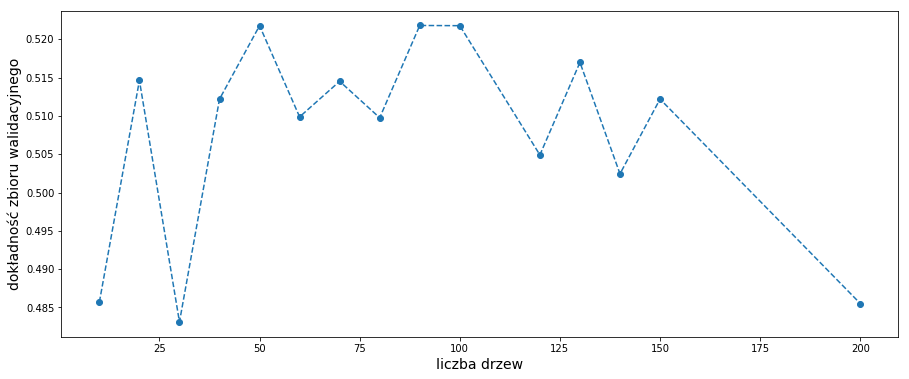

In [33]:
val = [] 
n_estimators = []
for n in sorted(results):
    val_accuracy = results[n]
    val.append(val_accuracy)
    n_estimators.append(n)
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.plot(n_estimators[:-2], val[:-2], 'o--')
ax.set_xlabel('liczba drzew', fontsize=14)
ax.set_ylabel('dokładność zbioru walidacyjnego', fontsize=14)

In [31]:
prediction = best_model.predict(X_test)

# Evaluation

In [32]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        60
           1       0.54      0.57      0.56        44

   micro avg       0.62      0.62      0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [30]:
print(confusion_matrix(y_test, prediction))

[[31 24]
 [23 26]]


In [31]:
feature_importance = clf.feature_importances_

[Text(0,0,'Maks'),
 Text(0,0,'Min'),
 Text(0,0,'RMS'),
 Text(0,0,'Kurt'),
 Text(0,0,'Skos')]

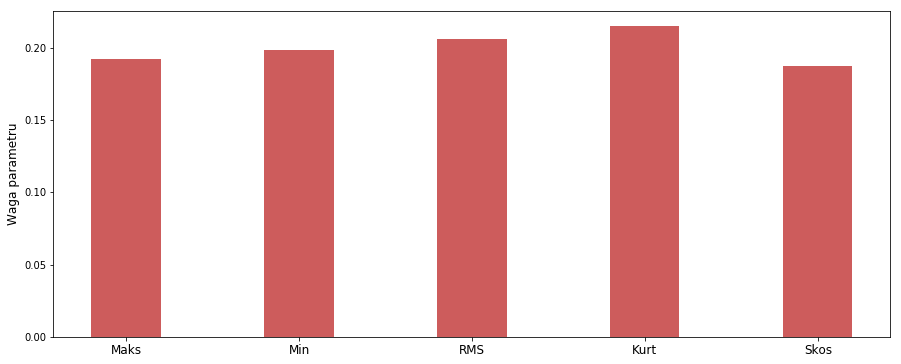

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.grid(b=False)
ind = np.arange(len(feature_importance))  # the x locations for the groups
width = 0.4  # the width of the bars
ax.bar(ind, feature_importance, width, color='IndianRed')
ax.set_ylabel('Waga parametru', fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(['Maks', 'Min', 'RMS', 'Kurt', 'Skos'], fontsize=12)

In [33]:
feature_importance

array([0.1922019 , 0.19854994, 0.20642033, 0.21513842, 0.1876894 ])